In [2]:
# 调用相关库
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas import DataFrame
from pandas import concat
import numpy
from sklearn.neural_network import MLPRegressor
import os

In [3]:
# 加载数据集
dataset = pd.read_excel("Tibet.xlsx")
fratures_Corrected_irradiance = [
   '震级(M)', '纬度(°)', '经度(°)'
]
values= dataset[fratures_Corrected_irradiance].values

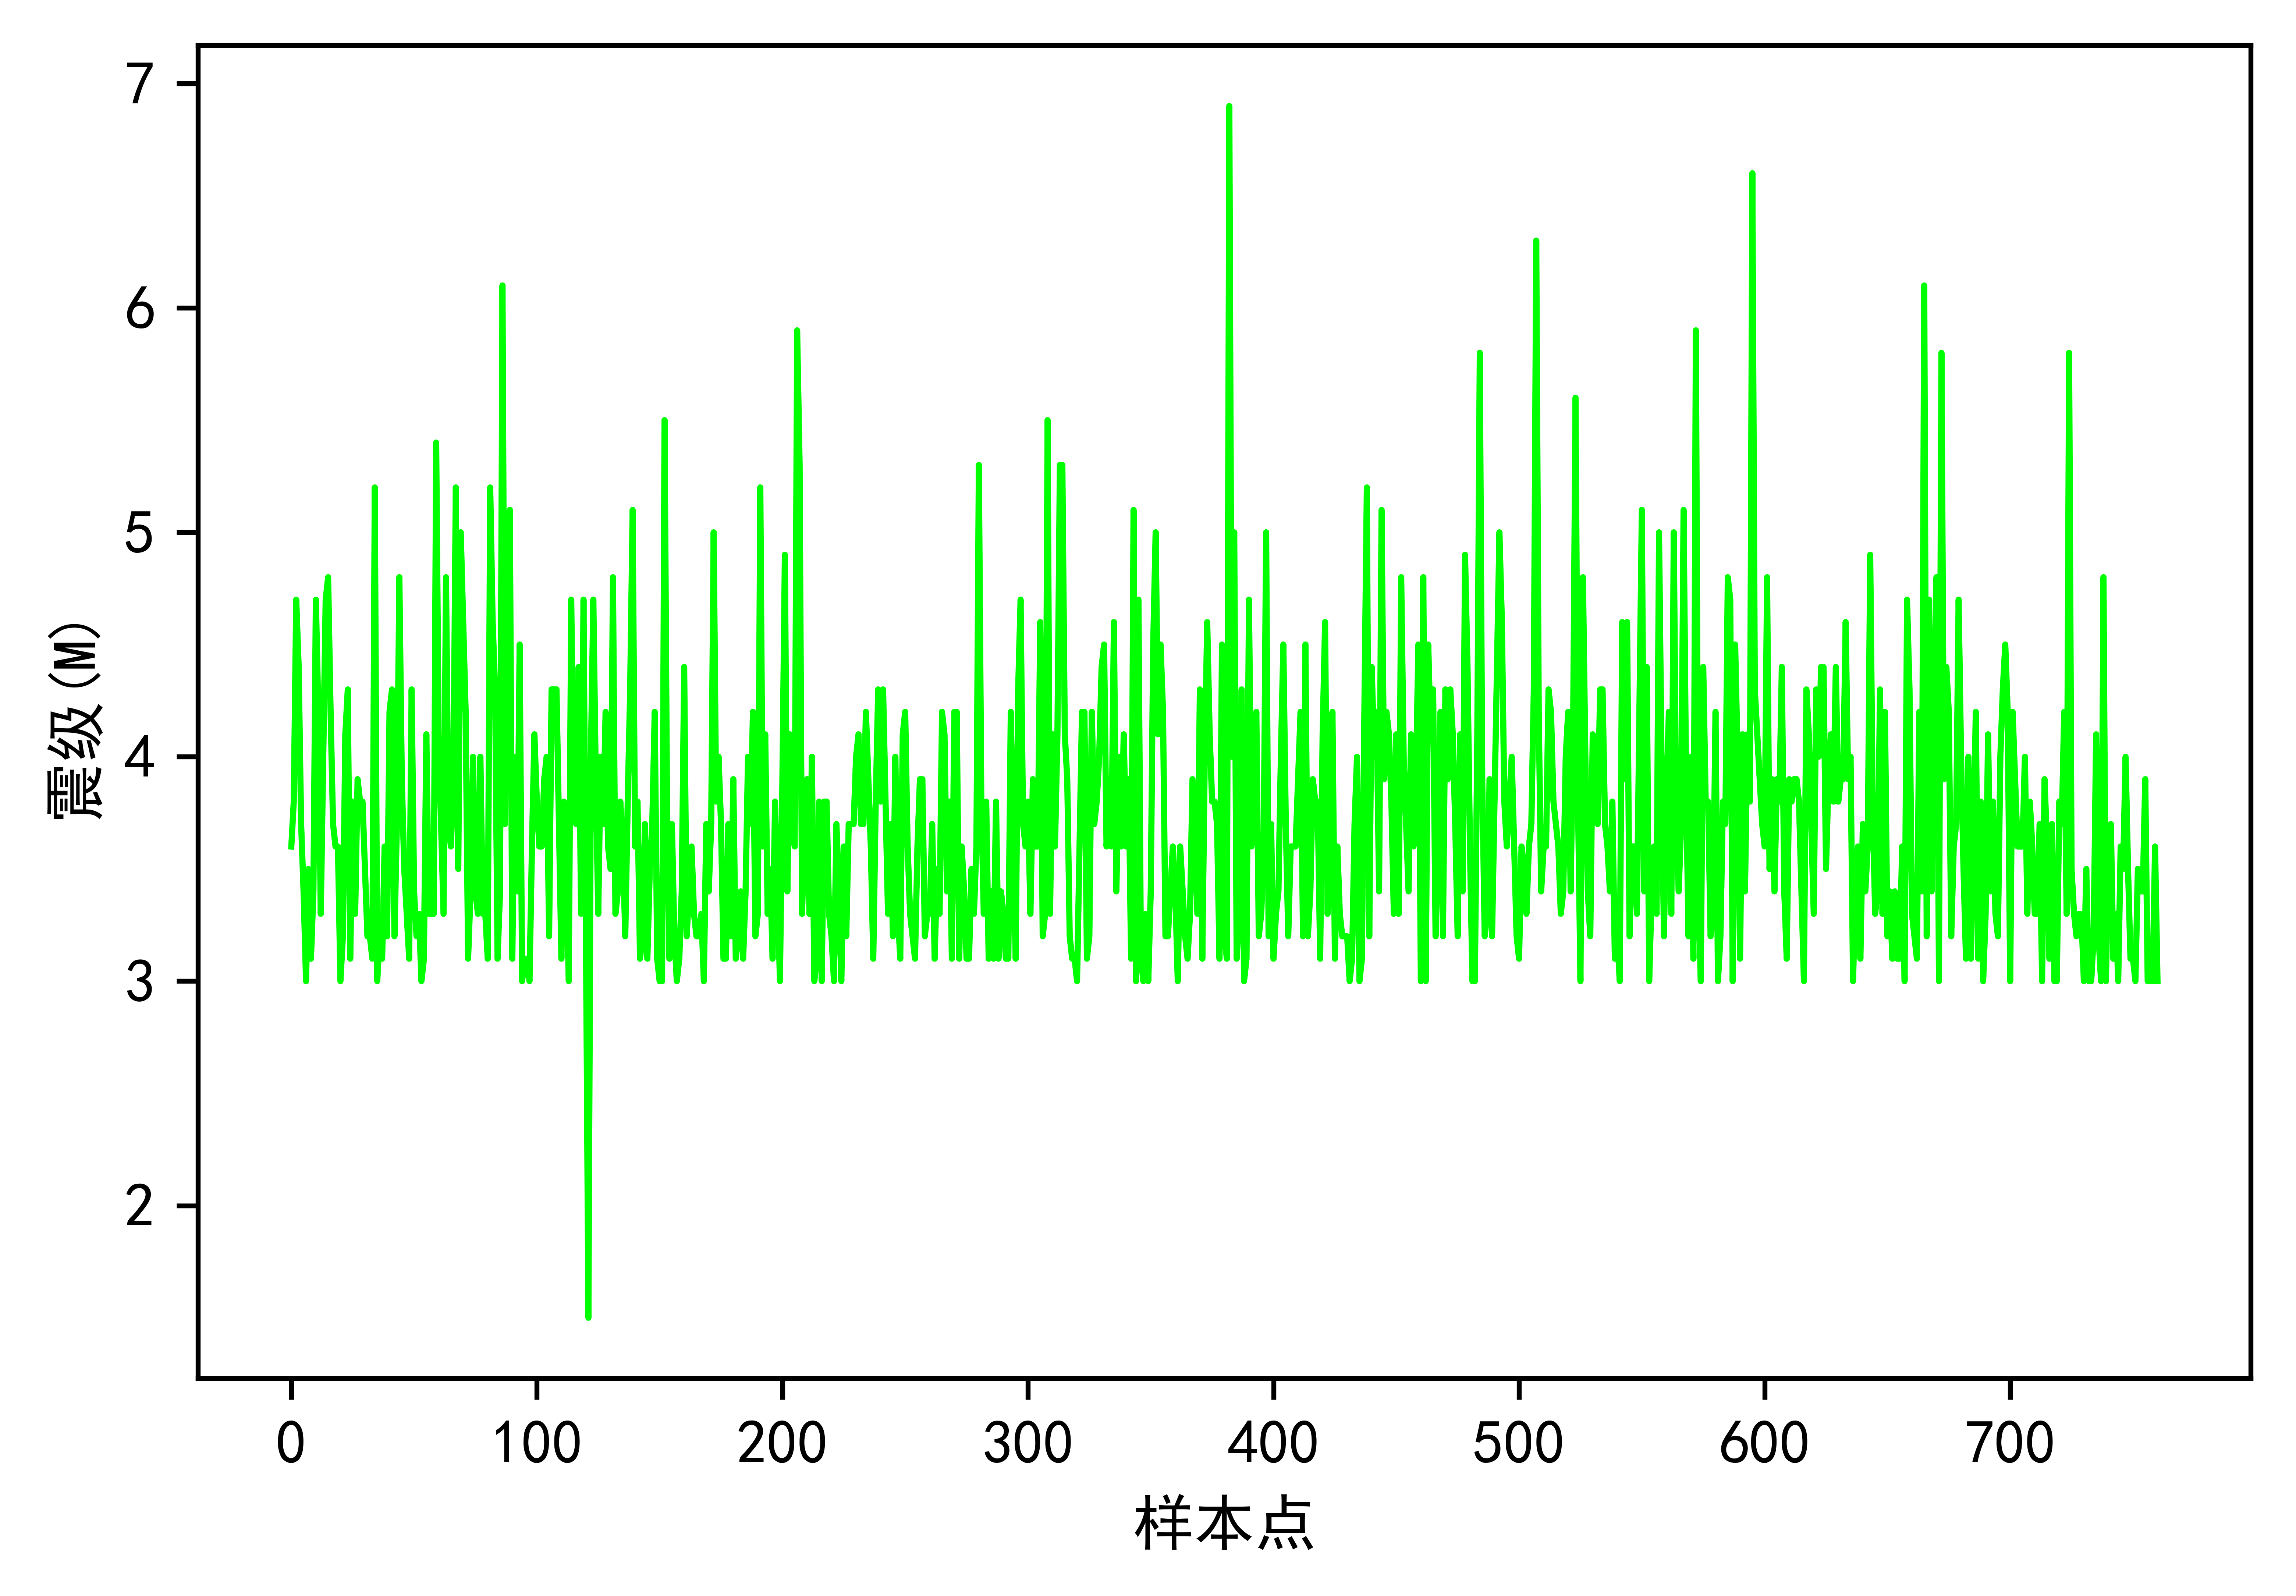

In [4]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.sans-serif']=['Simhei']  #解决画图中文不显示问题
plt.figure(figsize=(6,4),dpi=600) 
data10=dataset['震级(M)'].values
plt.tick_params(labelsize=10)  #改变刻度字体大小
plt.plot(data10, color='lime',linewidth=1)
plt.rcParams.update({'font.size': 10})  #改变图例里面的字体大小
plt.xlabel("样本点",fontsize=10)
plt.ylabel("震级(M)",fontsize=10)
# plt.savefig('西藏十年震级原始数据图.png')
plt.show()

In [5]:
data=values
close = data[:,0]
close.shape

(761,)

In [5]:
import numpy as np
import math

def VMD(signal, alpha, tau, K, DC, init, tol):
    # ---------------------
    #  signal  - the time domain signal (1D) to be decomposed
    #  alpha   - the balancing parameter of the data-fidelity constraint
    #  tau     - time-step of the dual ascent ( pick 0 for noise-slack )
    #  K       - the number of modes to be recovered
    #  DC      - true if the first mode is put and kept at DC (0-freq)
    #  init    - 0 = all omegas start at 0
    #                     1 = all omegas start uniformly distributed
    #                     2 = all omegas initialized randomly
    #  tol     - tolerance of convergence criterion; typically around 1e-6
    #
    #  Output:
    #  -------
    #  u       - the collection of decomposed modes
    #  res     - residual
    #  u_hat   - spectra of the modes
    #  omega   - estimated mode center-frequencies
    

    
    # Period and sampling frequency of input signal
    save_T=len(signal)
    fs=1/float(save_T)

    # extend the signal by mirroring
    T=save_T
    # print(T)
    f_mirror=np.zeros(2*T)
    #print(f_mirror)
    f_mirror[0:T//2]=signal[T//2-1::-1]
    # print(f_mirror)
    f_mirror[T//2:3*T//2]= signal
    # print(f_mirror)
    f_mirror[3*T//2:2*T]=signal[-1:-T//2-1:-1]
    # print(f_mirror)
    f=f_mirror
    # print('f_mirror')
    # print(f_mirror)
    # print('-------')

    # Time Domain 0 to T (of mirrored signal)
    T=float(len(f))
    # print(T)
    t=np.linspace(1/float(T),1,int(T),endpoint=True)
    # print(t)

    # Spectral Domain discretization
    freqs=t-0.5-1/T
    # print(freqs)
    # print('-----')
    # Maximum number of iterations (if not converged yet, then it won't anyway)
    N=500

    # For future generalizations: individual alpha for each mode
    Alpha=alpha*np.ones(K,dtype=complex)
    # print(Alpha.shape)
    # print(Alpha)
    # print('-----')

    # Construct and center f_hat
    f_hat=np.fft.fftshift(np.fft.fft(f))
    # print('f_hat')
    # print(f_hat.shape)
    # print(f_hat)
    # print('-----')
    f_hat_plus=f_hat
    f_hat_plus[0:int(int(T)/2)]=0
    # print('f_hat_plus')
    # print(f_hat_plus.shape)
    # print(f_hat_plus)
    # print('-----')
    # matrix keeping track of every iterant // could be discarded for mem
    u_hat_plus=np.zeros((N,len(freqs),K),dtype=complex)
    # print('u_hat_plus')
    # print(u_hat_plus.shape)
    # print(u_hat_plus)
    # print('-----')


    # Initialization of omega_k
    omega_plus=np.zeros((N,K),dtype=complex)
    # print('omega_plus')
    # print(omega_plus.shape)
    # print(omega_plus)
                        
    if (init==1):
        for i in range(1,K+1):
            omega_plus[0,i-1]=(0.5/K)*(i-1)
    elif (init==2):
        omega_plus[0,:]=np.sort(math.exp(math.log(fs))+(math.log(0.5)-math.log(fs))*np.random.rand(1,K))
    else:
        omega_plus[0,:]=0

    if (DC):
        omega_plus[0,0]=0

    # print('omega_plus')
    # print(omega_plus.shape)
    # print(omega_plus)

    # start with empty dual variables
    lamda_hat=np.zeros((N,len(freqs)),dtype=complex)

    # other inits
    uDiff=tol+2.2204e-16 #updata step
    # print('uDiff')
    # print(uDiff)
    # print('----')
    n=1 #loop counter
    sum_uk=0 #accumulator

    T=int(T)


    # ----------- Main loop for iterative updates

    while uDiff > tol and n<N:
        # update first mode accumulator
        k=1
        sum_uk = u_hat_plus[n-1,:,K-1]+sum_uk-u_hat_plus[n-1,:,0]
    #     print('sum_uk')
    #     print(sum_uk)
        #update spectrum of first mode through Wiener filter of residuals
        u_hat_plus[n,:,k-1]=(f_hat_plus-sum_uk-lamda_hat[n-1,:]/2)/(1+Alpha[k-1]*np.square(freqs-omega_plus[n-1,k-1]))
    #     print('u_hat_plus')
    #     print(u_hat_plus.shape)
    #     print(u_hat_plus[n,:,k-1])
    #     print('-----')
        
        

        #update first omega if not held at 0
        if DC==False:
            omega_plus[n,k-1]=np.dot(freqs[T//2:T],np.square(np.abs(u_hat_plus[n,T//2:T,k-1])).T)/np.sum(np.square(np.abs(u_hat_plus[n,T//2:T,k-1])))


        for k in range(2,K+1):

            #accumulator
            sum_uk=u_hat_plus[n,:,k-2]+sum_uk-u_hat_plus[n-1,:,k-1]
    #         print('sum_uk'+str(k))
    #         print(sum_uk)


            #mode spectrum
            u_hat_plus[n,:,k-1]=(f_hat_plus-sum_uk-lamda_hat[n-1,:]/2)/(1+Alpha[k-1]*np.square(freqs-omega_plus[n-1,k-1]))
    #         print('u_hat_plus'+str(k))
    #         print(u_hat_plus[n,:,k-1])
            
            #center frequencies
            omega_plus[n,k-1]=np.dot(freqs[T//2:T],np.square(np.abs(u_hat_plus[n,T//2:T,k-1])).T)/np.sum(np.square(np.abs(u_hat_plus[n,T//2:T:,k-1])))
    #         print('omega_plus'+str(k))
    #         print(omega_plus[n,k-1])
        #Dual ascent
    #     print(u_hat_plus.shape)
        lamda_hat[n,:]=lamda_hat[n-1,:]+tau*(np.sum(u_hat_plus[n,:,:],axis=1)-f_hat_plus)
    #     print('lamda_hat'+str(n))
    #     print(lamda_hat[n,:])

        #loop counter
        n=n+1

        #converged yet?
        uDiff=2.2204e-16

        for i in range(1,K+1):
            uDiff=uDiff+1/float(T)*np.dot(u_hat_plus[n-1,:,i-1]-u_hat_plus[n-2,:,i-1],(np.conj(u_hat_plus[n-1,:,i-1]-u_hat_plus[n-2,:,i-1])).conj().T)

            
        
        uDiff=np.abs(uDiff)
        # print('uDiff')
        # print(uDiff)

        
    # ------ Postprocessing and cleanup

    # discard empty space if converged early

    N=np.minimum(N,n)
    omega = omega_plus[0:N,:]

    # Signal reconstruction
    u_hat = np.zeros((T,K),dtype=complex)
    u_hat[T//2:T,:]= np.squeeze(u_hat_plus[N-1,T//2:T,:])
    # print('u_hat')
    # print(u_hat.shape)
    # print(u_hat)
    u_hat[T//2:0:-1,:]=np.squeeze(np.conj(u_hat_plus[N-1,T//2:T,:]))
    u_hat[0,:]=np.conj(u_hat[-1,:])
    # print('u_hat')
    # print(u_hat)
    u=np.zeros((K,len(t)),dtype=complex)

    for k in range(1,K+1):
        u[k-1,:]= np.real(np.fft.ifft(np.fft.ifftshift(u_hat[:,k-1])))


    # remove mirror part 
    u=u[:,T//4:3*T//4]
    u=np.real(u)
    
    res=signal-u.sum(axis=0)
    # print(u_hat.shape)
    #recompute spectrum
    u_hat = np.zeros((T//2,K),dtype=complex)

    for k in range(1,K+1):
        u_hat[:,k-1]=np.fft.fftshift(np.fft.fft(u[k-1,:])).conj().T
        
        
    return (u,u_hat,omega)

In [6]:
# In[] vmd分解-直接设置参数
alpha = 50
k = 6    
tau = 0  
DC = 0         
init = 1         
tol = 1e-7
u,u_hat,omega=VMD(close, alpha, tau, k, DC, init, tol)

In [7]:
from matplotlib import rcParams


import seaborn as sns

plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.rcParams['font.family'] = ['sans-serif']
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.sans-serif']=['Simhei']  #解决画图中文不显示问题
plt.rcParams['xtick.direction'] = 'in'#将x周的刻度线方向设置向内
plt.rcParams['ytick.direction'] = 'in'#将y轴的刻度方向设置向内
plt.figure(figsize=(10,8), dpi=500)
for i in range(k):
    plt.rcParams['font.family'] = ['sans-serif']

   
    plt.subplot(k,1,i+1)
    plt.plot(u[i,:], 'r',linewidth=1)
    plt.xlabel("样本点数/个")
    plt.ylabel('IMF{}'.format(i+1))
# plt.savefig('西藏十年VMD分解结果.png')

In [8]:
### 构建时间序列特征集
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [9]:
i = 1
svr = []
prediction_test = []
actual_test = []

for imf in u:
    imf=imf.reshape(-1,1)
    imf=pd.DataFrame(imf)
    data_1=pd.DataFrame(data[:,1:])
    data_=pd.concat((imf,data_1), axis=1)
    data_=data_.values
    data_ = data_.astype('float32')
    
    # 构建成监督学习问题
    n_in=3
    n_out=1
    n_vars=3
# 构建成监督学习问题
    reframed = series_to_supervised(data_, n_in, n_out)  # 预测时间步长为3 ，输出时间步1  ，即由t-3,t-2,....t-1预测t
    #取出保留的变量
    contain_vars = []
    for i in range(1, n_in+1):
        contain_vars += [('var%d(t-%d)' % (j, i)) for j in range(1,n_vars+1)]  
    data3 = reframed [ contain_vars + ['var1(t)'] + [('var1(t+%d)' % (j)) for j in range(1,n_out)]]
    values = data3.values
    n_train_hours =609 # 区分训练集和测试集
    train = values[:n_train_hours, :]  
    test = values[n_train_hours:, :]   
    # 归一化
    scaler =  StandardScaler()
    train = scaler.fit_transform(train)
    test =  scaler.fit_transform(test)
    # 把数据分为输入和输出
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    train_y=train_y.reshape(len(train_y))


    bp = MLPRegressor(hidden_layer_sizes=(50,),  max_iter=100, random_state=10,verbose=2) 
    tmp=bp.fit(train_X, train_y)
    svr.append(tmp)
    
    
    
    # 作出预测
    yhat = tmp.predict(test_X)
    yhat=yhat.reshape(-1,1)
    yhat = np.repeat(yhat,n_in*n_vars+n_out, axis=-1)
    inv_yhat=scaler.inverse_transform(np.reshape(yhat,(len(yhat),n_in*n_vars+n_out)))[:,0]
    prediction_test.append(inv_yhat)
    test_y=test_y.reshape(-1,1)
    y = np.repeat(test_y,n_in*n_vars+n_out, axis=-1)
    inv_y=scaler.inverse_transform(np.reshape(y,(len(test_y),n_in*n_vars+n_out)))[:,0]
    actual_test.append(inv_y)
    

    
    
i=i+1


Iteration 1, loss = 0.64542890
Iteration 2, loss = 0.54161852
Iteration 3, loss = 0.45093857
Iteration 4, loss = 0.37422267
Iteration 5, loss = 0.30484899
Iteration 6, loss = 0.24999574
Iteration 7, loss = 0.20354904
Iteration 8, loss = 0.16556696
Iteration 9, loss = 0.13482704
Iteration 10, loss = 0.11180192
Iteration 11, loss = 0.09282748
Iteration 12, loss = 0.07978546
Iteration 13, loss = 0.06994387
Iteration 14, loss = 0.06364420
Iteration 15, loss = 0.05917583
Iteration 16, loss = 0.05604547
Iteration 17, loss = 0.05369298
Iteration 18, loss = 0.05173212
Iteration 19, loss = 0.05024618
Iteration 20, loss = 0.04884540
Iteration 21, loss = 0.04743196
Iteration 22, loss = 0.04610183
Iteration 23, loss = 0.04479075
Iteration 24, loss = 0.04348699
Iteration 25, loss = 0.04202414
Iteration 26, loss = 0.04075267
Iteration 27, loss = 0.03958867
Iteration 28, loss = 0.03871381
Iteration 29, loss = 0.03787152
Iteration 30, loss = 0.03697359
Iteration 31, loss = 0.03607910
Iteration 32, los

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 34, loss = 0.07739184
Iteration 35, loss = 0.07450062
Iteration 36, loss = 0.07160264
Iteration 37, loss = 0.06906546
Iteration 38, loss = 0.06680091
Iteration 39, loss = 0.06468618
Iteration 40, loss = 0.06303781
Iteration 41, loss = 0.06089961
Iteration 42, loss = 0.05844702
Iteration 43, loss = 0.05613394
Iteration 44, loss = 0.05429517
Iteration 45, loss = 0.05274850
Iteration 46, loss = 0.05129371
Iteration 47, loss = 0.05003175
Iteration 48, loss = 0.04892020
Iteration 49, loss = 0.04781841
Iteration 50, loss = 0.04679681
Iteration 51, loss = 0.04557472
Iteration 52, loss = 0.04449778
Iteration 53, loss = 0.04374642
Iteration 54, loss = 0.04311663
Iteration 55, loss = 0.04239553
Iteration 56, loss = 0.04152340
Iteration 57, loss = 0.04082407
Iteration 58, loss = 0.04021412
Iteration 59, loss = 0.03961238
Iteration 60, loss = 0.03888761
Iteration 61, loss = 0.03833537
Iteration 62, loss = 0.03783102
Iteration 63, loss = 0.03744062
Iteration 64, loss = 0.03704629
Iteratio

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 46, loss = 0.07189232
Iteration 47, loss = 0.07096068
Iteration 48, loss = 0.07015177
Iteration 49, loss = 0.06963157
Iteration 50, loss = 0.06892356
Iteration 51, loss = 0.06842729
Iteration 52, loss = 0.06790327
Iteration 53, loss = 0.06730658
Iteration 54, loss = 0.06688448
Iteration 55, loss = 0.06641399
Iteration 56, loss = 0.06582044
Iteration 57, loss = 0.06535559
Iteration 58, loss = 0.06499831
Iteration 59, loss = 0.06468745
Iteration 60, loss = 0.06437753
Iteration 61, loss = 0.06383450
Iteration 62, loss = 0.06305468
Iteration 63, loss = 0.06236285
Iteration 64, loss = 0.06219929
Iteration 65, loss = 0.06195194
Iteration 66, loss = 0.06151076
Iteration 67, loss = 0.06078005
Iteration 68, loss = 0.06052143
Iteration 69, loss = 0.06020585
Iteration 70, loss = 0.05974679
Iteration 71, loss = 0.05945712
Iteration 72, loss = 0.05900807
Iteration 73, loss = 0.05826623
Iteration 74, loss = 0.05792179
Iteration 75, loss = 0.05749700
Iteration 76, loss = 0.05689687
Iteratio

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 57, loss = 0.05343513
Iteration 58, loss = 0.05320290
Iteration 59, loss = 0.05298768
Iteration 60, loss = 0.05252447
Iteration 61, loss = 0.05201304
Iteration 62, loss = 0.05161643
Iteration 63, loss = 0.05144076
Iteration 64, loss = 0.05114412
Iteration 65, loss = 0.05060512
Iteration 66, loss = 0.05026681
Iteration 67, loss = 0.05005693
Iteration 68, loss = 0.05011414
Iteration 69, loss = 0.04972820
Iteration 70, loss = 0.04945305
Iteration 71, loss = 0.04958333
Iteration 72, loss = 0.04932593
Iteration 73, loss = 0.04888516
Iteration 74, loss = 0.04861294
Iteration 75, loss = 0.04841337
Iteration 76, loss = 0.04810157
Iteration 77, loss = 0.04774599
Iteration 78, loss = 0.04742276
Iteration 79, loss = 0.04725658
Iteration 80, loss = 0.04720221
Iteration 81, loss = 0.04715579
Iteration 82, loss = 0.04685079
Iteration 83, loss = 0.04650589
Iteration 84, loss = 0.04617331
Iteration 85, loss = 0.04599178
Iteration 86, loss = 0.04593991
Iteration 87, loss = 0.04598033
Iterati

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 13, loss = 0.30027451
Iteration 14, loss = 0.27617546
Iteration 15, loss = 0.25462175
Iteration 16, loss = 0.23548583
Iteration 17, loss = 0.21788352
Iteration 18, loss = 0.20113837
Iteration 19, loss = 0.18579737
Iteration 20, loss = 0.17230250
Iteration 21, loss = 0.16015229
Iteration 22, loss = 0.14986302
Iteration 23, loss = 0.13999065
Iteration 24, loss = 0.13169138
Iteration 25, loss = 0.12393362
Iteration 26, loss = 0.11651227
Iteration 27, loss = 0.11018453
Iteration 28, loss = 0.10482347
Iteration 29, loss = 0.10018547
Iteration 30, loss = 0.09599814
Iteration 31, loss = 0.09247437
Iteration 32, loss = 0.08947168
Iteration 33, loss = 0.08672682
Iteration 34, loss = 0.08441140
Iteration 35, loss = 0.08204716
Iteration 36, loss = 0.08015866
Iteration 37, loss = 0.07846614
Iteration 38, loss = 0.07717697
Iteration 39, loss = 0.07582077
Iteration 40, loss = 0.07471647
Iteration 41, loss = 0.07371880
Iteration 42, loss = 0.07275968
Iteration 43, loss = 0.07203370
Iterati

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 19, loss = 0.15642531
Iteration 20, loss = 0.15027568
Iteration 21, loss = 0.14437871
Iteration 22, loss = 0.13853947
Iteration 23, loss = 0.13293615
Iteration 24, loss = 0.12789200
Iteration 25, loss = 0.12321720
Iteration 26, loss = 0.11838285
Iteration 27, loss = 0.11376656
Iteration 28, loss = 0.10937335
Iteration 29, loss = 0.10507755
Iteration 30, loss = 0.10123811
Iteration 31, loss = 0.09726820
Iteration 32, loss = 0.09344098
Iteration 33, loss = 0.08950316
Iteration 34, loss = 0.08576532
Iteration 35, loss = 0.08195339
Iteration 36, loss = 0.07843892
Iteration 37, loss = 0.07518436
Iteration 38, loss = 0.07191437
Iteration 39, loss = 0.06857056
Iteration 40, loss = 0.06566993
Iteration 41, loss = 0.06303712
Iteration 42, loss = 0.06056549
Iteration 43, loss = 0.05819519
Iteration 44, loss = 0.05603578
Iteration 45, loss = 0.05401977
Iteration 46, loss = 0.05207370
Iteration 47, loss = 0.05005890
Iteration 48, loss = 0.04772139
Iteration 49, loss = 0.04574447
Iteratio

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [10]:
mean_pre_test = []                    

for i in range(0,len(prediction_test[0])):
    sum = 0
    for j in range(0,len(prediction_test)):
        sum = sum + prediction_test[j][i]
    
#     mean = sum/len(prediction_test) 
    mean_pre_test.append(sum)
        
mean_pre_test        

[4.064823831510493,
 4.033692218323551,
 3.8829095575368493,
 3.5006794956724785,
 3.075313138356933,
 4.294921962795705,
 4.294378739319638,
 3.8543909670368106,
 3.3340645376406415,
 4.316922570766959,
 4.027220218812437,
 4.357205324421785,
 4.381304059204938,
 3.5793923080719714,
 4.0194947483991195,
 3.8985065524478637,
 3.814697280465095,
 4.526330221219061,
 3.8963475333689908,
 3.948991410090415,
 4.0198026806099225,
 4.652336773949754,
 4.104943702837808,
 4.205821159759769,
 3.2980806281031434,
 3.551326535040524,
 3.546288700696689,
 3.262659007486372,
 3.784357898450002,
 3.5013913829194703,
 3.70294782643566,
 4.603579793619757,
 3.7795853666985675,
 3.224982458476255,
 3.531856846667797,
 4.099791307377929,
 3.354067359632991,
 4.108143107180553,
 3.162961423810881,
 3.4751400279082576,
 3.170225504418709,
 3.3271422446906733,
 3.314621383892112,
 3.312760737097299,
 3.73646155829527,
 2.849392889260491,
 4.6510888627580735,
 4.098253109867763,
 3.3709979488208788,
 3.177

In [11]:
mean_actual_test = []

for i in range(0,len(actual_test[0])):
    sum = 0
    for j in range(0,len(actual_test)):
        sum = sum + actual_test[j][i]
    
#     mean = sum/len(actual_test)
    mean_actual_test.append(sum)
        
mean_actual_test    

[3.9206346729770303,
 3.8953193724155426,
 3.80701293842867,
 3.4091802686452866,
 3.032432734966278,
 4.278818290680647,
 4.112792856991291,
 3.701991133391857,
 3.317478708922863,
 4.286857925355434,
 4.006668221205473,
 4.374781635240652,
 4.39189800620079,
 3.5015032244846225,
 3.909488333389163,
 4.079710585065186,
 3.803166603669524,
 4.390619482845068,
 3.812254657037556,
 3.893497034907341,
 3.916963901370764,
 4.565388955175877,
 3.900880455970764,
 4.0040626004338264,
 3.033932752907276,
 3.397724929411197,
 3.6153933168388903,
 3.09932829067111,
 3.713337689638138,
 3.4054414220154285,
 3.6145675741136074,
 4.8619732186198235,
 3.8134412094950676,
 3.3211150020360947,
 3.4275085462722927,
 4.295432381797582,
 3.3159056901931763,
 4.1788257621228695,
 3.2154966443777084,
 3.412553772330284,
 3.131118044257164,
 3.3933197874575853,
 3.152258522808552,
 3.1002215147018433,
 3.6226518228650093,
 3.0097399204969406,
 4.699381469748914,
 4.287625323981047,
 3.3201770605519414,
 3.

In [12]:
# 计算RMSE
rmse = sqrt(mean_squared_error(mean_actual_test, mean_pre_test))
print('Test RMSE: %.7f' % rmse)
print('Test MAE: %.7f' % mean_absolute_error(mean_actual_test, mean_pre_test))
print('Test R2: %.7f' % r2_score(mean_actual_test, mean_pre_test))

Test RMSE: 0.1571442
Test MAE: 0.1209320
Test R2: 0.9226467


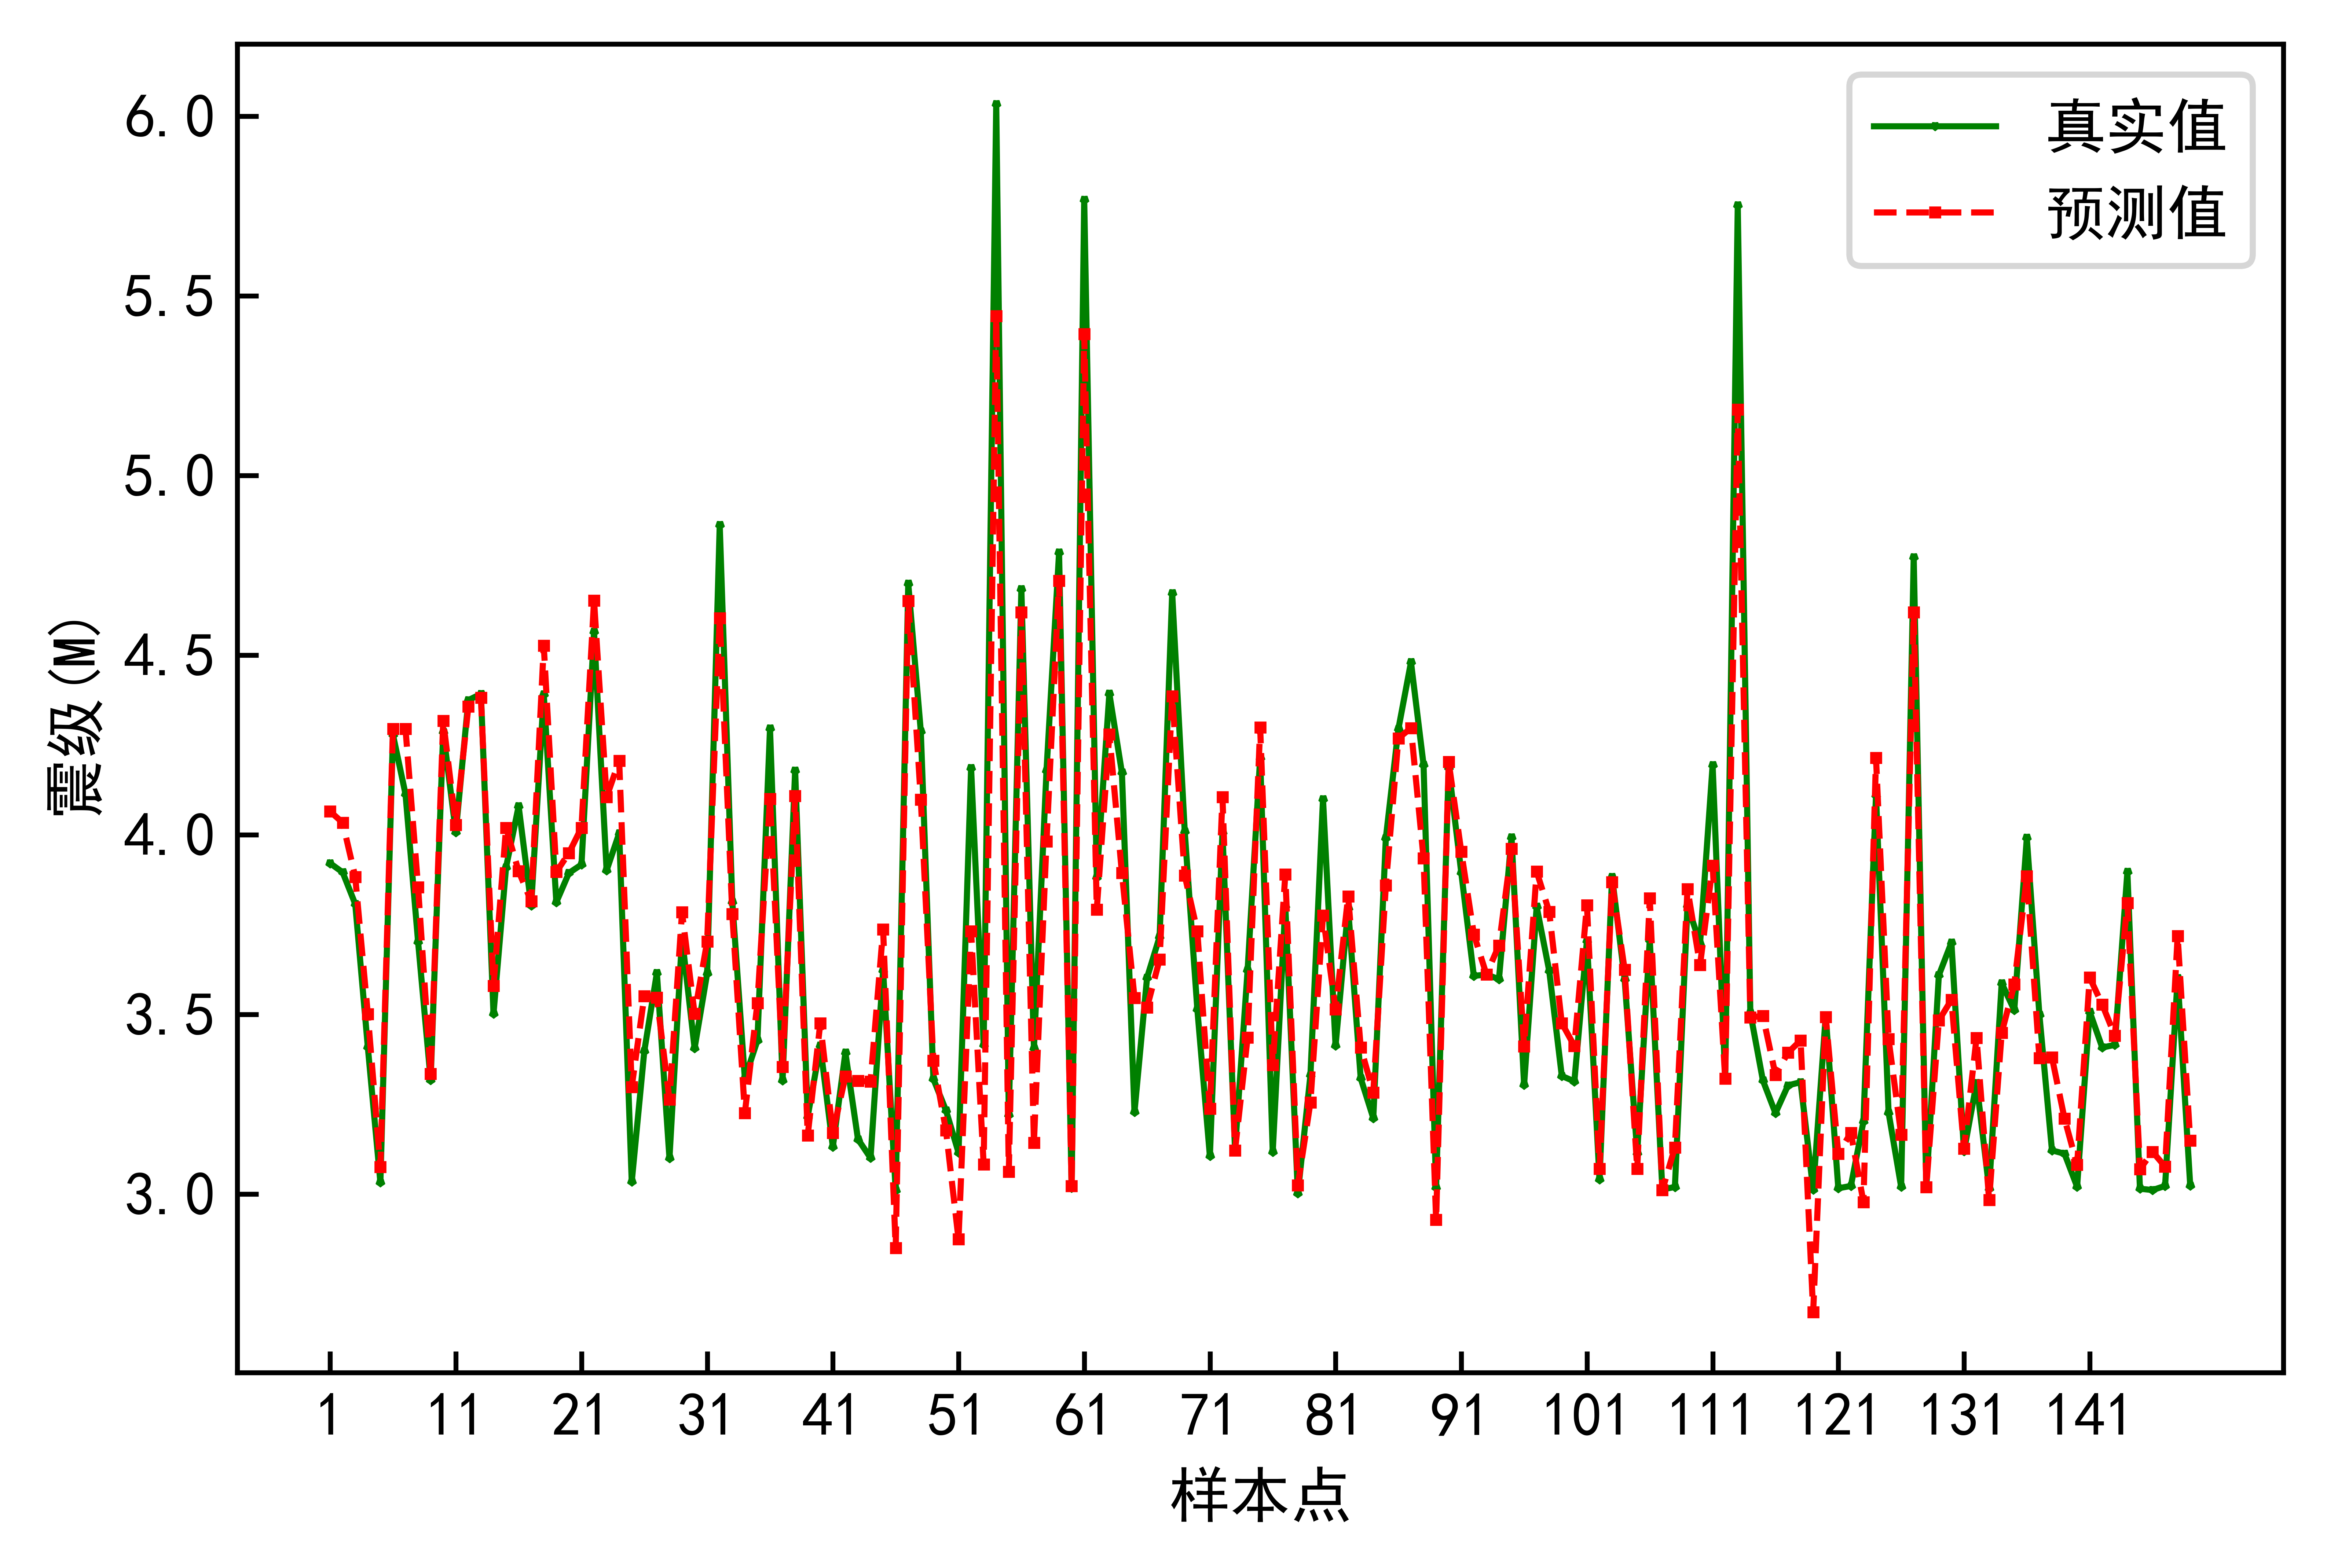

In [13]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.sans-serif']=['Simhei']  #解决画图中文不显示问题
plt.figure(figsize=(6,4),dpi=600)
#添加网格线,linestyle表示绘制网格线的形式，alpha表示透明度
# plt.grid(True,linestyle="--",alpha=0.5)  
x=range(1, len(mean_pre_test) + 1)
plt.xticks(x[::10])
plt.tick_params(labelsize=10)  #改变刻度字体大小
plt.plot(x, mean_actual_test, marker='*',markersize='1',color='g',linewidth=1, label='真实值')
plt.plot(x, mean_pre_test, marker='s',markersize='1', color='red',linestyle="--",linewidth=1,label='预测值')
plt.rcParams.update({'font.size': 10})  #改变图例里面的字体大小
plt.legend(loc='upper right')
plt.xlabel("样本点",fontsize=10)
plt.ylabel("震级(M)",fontsize=10)
plt.legend()
# plt.savefig('西藏十年VMD-BP震级预测结果图.png')
plt.show()